In [1]:
import sys
sys.path.append('..')

from nes import nes_attack
from hsja import hop_skip_jump_attack

# Helper imports
from data import CIFAR10, IMAGENETTE
import utils

# Numerical computing and display imports
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

# Other imports
from datetime import datetime
import os

/Users/neddamj/miniforge3/envs/nhash/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and Prepare the Data
folder_path = '../../images/'
dataset = 'imagenette'    
if dataset == 'cifar10':
    images = CIFAR10()
if dataset == 'imagenette':
    images = IMAGENETTE()
x = images.load()
images.save_to_disk(x, folder_path, num_images=100)
folder_path = utils.move_data_to_temp_ram(folder_path, ram_size_mb=50)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-10-19 10:18:58.493698: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[INFO] Images saved
Started erase on disk4
Unmounting disk
Erasing
Initialized /dev/rdisk4 as a 50 MB case-insensitive HFS Plus volume
Mounting disk
Finished erase on disk4 (TempRAM)
[INFO] RAM Disk Created...
[INFO] Files moved to temp RAM...


In [7]:
# Threshold-hyperparameter mappings
threshold_hyperparam = {
    '1':  {'nes_l2_threshold': 25, 'nes_l2_tolerance': 10, 'hsja_l2_threshold': 10},
    '5':  {'nes_l2_threshold': 35, 'nes_l2_tolerance': 12, 'hsja_l2_threshold': 15},
    '10': {'nes_l2_threshold': 45, 'nes_l2_tolerance': 15, 'hsja_l2_threshold': 20},
    '19': {'nes_l2_threshold': 55, 'nes_l2_tolerance': 20, 'hsja_l2_threshold': 24}# l2_tolerance: 15 ... hsja_l2_threshold: 25
}
attack_hamming_threshold = int(0.2 * 96 + 0.5) 

# NES Hyperparams
nes_mean =  -0.025 
nes_std = 0.1
nes_sigma = 0.7
nes_eps = 0.1                      
nes_l2_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['nes_l2_threshold'] 
nes_l2_tolerance = threshold_hyperparam[str(attack_hamming_threshold)]['nes_l2_tolerance'] 
nes_num_samples = 50

# HSJA Hyperparams
hsja_max_steps = 10
hsja_grad_queries = 20
hsja_l2_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['hsja_l2_threshold']

# Other params
ssim_threshold = 0.8

# Date and time
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")

In [8]:
def nes_joint_attack(img_path,
                     nes_mean, 
                     nes_std,
                     nes_sigma,
                     nes_eps, 
                     nes_l2_threshold,
                     nes_l2_tolerance,
                     nes_num_samples,
                     hsja_max_steps,
                     hsja_grad_queries,
                     hsja_l2_threshold,
                     hsja_hamming_threshold):
    # Soft-label attack
    img = utils.load_img(img_path)
    perturbed_img, nes_queries = nes_attack(img, mean=nes_mean, std=nes_std, sigma=nes_sigma, eps=nes_eps, l2_threshold=nes_l2_threshold, l2_tolerance=nes_l2_tolerance, num_samples=nes_num_samples)
    # Save perturbed image
    nes_filename = '../../images/perturbed.jpeg'
    utils.save_img(nes_filename, perturbed_img)

    # Hard-label attack
    (adv_img, hsja_queries) = hop_skip_jump_attack(orig_img_path=img_path, 
        target_img_path=nes_filename, 
        max_iters=hsja_max_steps, 
        grad_queries=hsja_grad_queries, 
        l2_threshold=hsja_l2_threshold, 
        hamming_threshold=hsja_hamming_threshold)
    
    return img, perturbed_img, adv_img, nes_queries, hsja_queries

In [9]:
for idx in range(100):
    img_path = f'../../images/{idx+1}.jpeg' 

    orig_img, nes_img, adv_img, nes_queries, hsja_queries = nes_joint_attack(img_path,
                                                                            nes_mean=nes_mean,
                                                                            nes_std=nes_std,
                                                                            nes_sigma=nes_sigma,
                                                                            nes_eps=nes_eps,
                                                                            nes_l2_threshold=nes_l2_threshold,
                                                                            nes_l2_tolerance=nes_l2_tolerance,
                                                                            nes_num_samples=nes_num_samples,
                                                                            hsja_max_steps=hsja_max_steps,
                                                                            hsja_grad_queries=hsja_grad_queries,
                                                                            hsja_l2_threshold=hsja_l2_threshold,
                                                                            hsja_hamming_threshold=attack_hamming_threshold)
    
    # Save the nes image and the final image
    utils.save_img(f'../../images/{idx+1}_nes.jpeg', nes_img)  
    utils.save_img(f'../../images/{idx+1}_final.jpeg', adv_img)
    
    orig_hash = utils.compute_hash(orig_img)
    nes_hash = utils.compute_hash(nes_img)
    adv_hash = utils.compute_hash(adv_img)
    nes_hamming_dist = utils.distance(orig_hash, nes_hash, "hamming")
    final_hamming_dist = utils.distance(orig_hash, adv_hash, 'hamming')
    nes_l2_dist = utils.distance(orig_img, nes_img, 'l2')
    final_l2_dist = utils.distance(orig_img, adv_img, 'l2')
    final_ssim = utils.distance(orig_img, adv_img.astype(np.uint8), 'ssim')
    total_queries = nes_queries + hsja_queries
    success = (final_hamming_dist >= attack_hamming_threshold) and (final_ssim >= ssim_threshold)

    attack_metrics = {
        'Image Path':    [img_path],
        'Success':       [success],
        'Queries':       [total_queries],
        'NES L2':        [nes_l2_dist],
        'Final L2':      [final_l2_dist],
        'Final SSIM':    [final_ssim],
        'NES Hamming':   [nes_hamming_dist],
        'Final Hamming': [final_hamming_dist]
    }

    # Save the results
    df = pd.DataFrame.from_dict(attack_metrics)
    file_path = f'metrics/nes/hamm_{attack_hamming_threshold}_l2_{hsja_l2_threshold}_{dt_string}.csv'
    if os.path.exists(file_path):
        df.to_csv(file_path, mode='a', index=False, header=False)
    else: 
        df.to_csv(file_path, index=False, header=True)
    
    

Estimating gradients with NES...
eps: 0.1 Lower Bound: 35 Upper Bound: 55 L2 Dist: 6.219168938349065
eps: 0.15000000000000002 Lower Bound: 35 Upper Bound: 55 L2 Dist: 9.099029695917762
eps: 0.22500000000000003 Lower Bound: 35 Upper Bound: 55 L2 Dist: 13.386608674745727
eps: 0.3375 Lower Bound: 35 Upper Bound: 55 L2 Dist: 19.763463235140417
eps: 0.5062500000000001 Lower Bound: 35 Upper Bound: 55 L2 Dist: 29.20996996320838
eps: 0.7593750000000001 Lower Bound: 35 Upper Bound: 55 L2 Dist: 43.098027261857624
BREAK
HSJA Iteration: 1
[INFO] Starting Boundary Search...
Hamming Dist: 50
L2 Dist: 32.708585490397496
Hamming Dist: 20
L2 Dist: 169.33920443645923
Hamming Dist: 13
L2 Dist: 84.66960221822961
Hamming Dist: 16
L2 Dist: 84.66960221822961
Hamming Dist: 19
L2 Dist: 84.66960221822961
Hamming Dist: 15
L2 Dist: 74.08590194093914
Hamming Dist: 18
L2 Dist: 74.08590194093914
Hamming Dist: 18
L2 Dist: 74.08590194093914
Hamming Dist: 18
L2 Dist: 74.08590194093914
Hamming Dist: 18
L2 Dist: 74.08590

KeyboardInterrupt: 

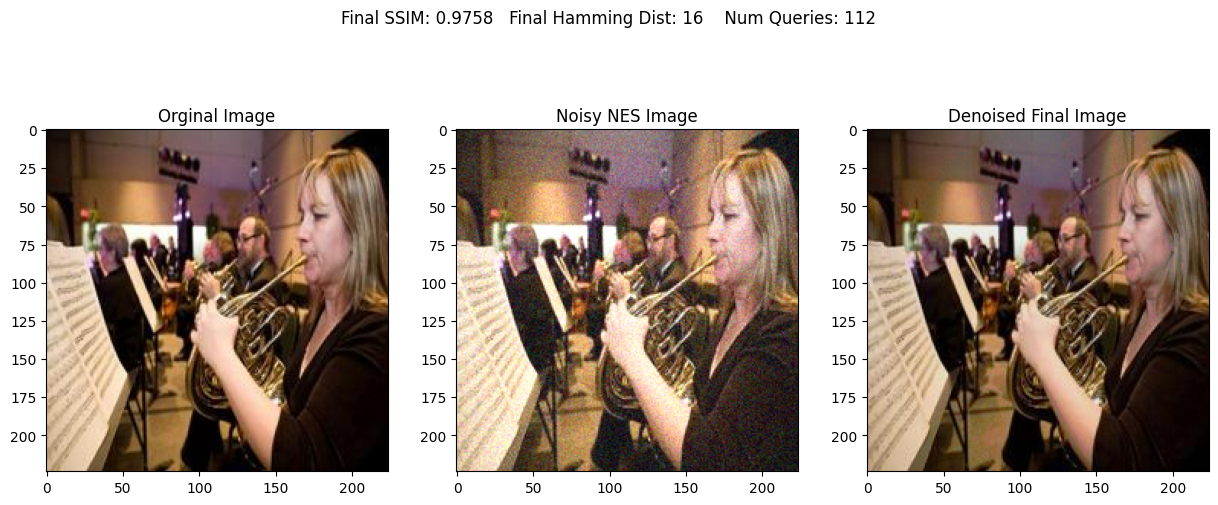

In [ ]:
def plot_results(orig_img, simba_img, adv_img, ssim, hamming_dist, num_queries):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
    fig.suptitle(f'Final SSIM: {ssim:.4f}   Final Hamming Dist: {hamming_dist}    Num Queries: {num_queries}')
    ax1.imshow(orig_img)
    ax1.set_title('Orginal Image') 
    ax2.imshow(simba_img)
    ax2.set_title('Noisy NES Image')
    ax3.imshow(adv_img.astype(np.uint8))
    ax3.set_title('Denoised Final Image')

# Show the images/results
num_queries = hsja_queries + nes_queries
plot_results(orig_img, nes_img, adv_img, utils.distance(orig_img, adv_img.astype(np.uint8), "ssim"), final_hamming_dist, num_queries)